This notebook has data cleaning and some feature engineering.

## Data Overview

In [708]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [709]:
df = pd.read_csv('datasets/train.csv')
df_test = pd.read_csv('datasets/test.csv')
base_residuals = pd.read_csv('datasets/base_residuals.csv', index_col=0)

In [710]:
df.shape

(2051, 81)

We'll examine different features relationship to home price as well as the residuals from our base model.
The base model is a linear regression trained on
* Neighborhood
* Overall Quality
* Year Built
* Gr Liv Area (above surface square footage)
* Year sold

In [711]:
base_residuals.columns = ['base_residual']

In [712]:
df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [713]:
df = df.join(base_residuals)

In [714]:
df.columns

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'G

In [715]:
df.dtypes

Id                 int64
PID                int64
MS SubClass        int64
MS Zoning         object
Lot Frontage     float64
                  ...   
Mo Sold            int64
Yr Sold            int64
Sale Type         object
SalePrice          int64
base_residual    float64
Length: 82, dtype: object

In [716]:
pd.DataFrame(df.isna().sum(), columns = ['na_count']).query('na_count > 0')

,na_count
Lot Frontage,330
Alley,1911
Mas Vnr Type,22
Mas Vnr Area,22
Bsmt Qual,55
Bsmt Cond,55
Bsmt Exposure,58
BsmtFin Type 1,55
BsmtFin SF 1,1
BsmtFin Type 2,56


## Helper Functions

### Display all columns

In [717]:
from IPython.display import display
def all_cols(df):
    with pd.option_context('display.max_columns', None):
        return display(df)

### Read Ordinal Scale

In [718]:
def read_map(map_):
    """map_ should be keyword 'qual' or "qual_na" or a dict. """

    # print(map_, type(map_))
    if type(map_) == dict:
        return map_

    elif type(map_) == list:
        return {val: i for i, val in enumerate(map_)}

    elif map_ == 'qual':
        return {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}

    elif map_ == 'qual_na':
        return {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

    else:
        return map_

In [719]:
def ord_read(col_name, map_ = 'qual', df = df):
    map_ = read_map(map_)

    return df[col_name].map(map_)
        

In [720]:
def ord_gb_price(col_name, map_ = 'qual', col = 'LogPrice_clipped', df = df):
    map_ = read_map(map_)
    r_map = {val: key for key, val in map_.items()}
    idx_order = [r_map[i] for i in sorted(r_map.keys())]
    return df.groupby(col_name).agg([np.mean, len])[[col]]\
        .reindex(idx_order)

In [721]:
def ord_plot(col_name, map_ = 'qual', col = 'LogPrice_clipped', df = df):
    map_ = read_map(map_)
    gb = ord_gb_price(col_name, map_, col, df)
    gb.index = pd.RangeIndex(len(gb.index))
    # print(gb)
    sns.scatterplot(
        x = gb.index, 
        y = gb[(col, 'mean')],
        s = 1 + 4*np.sqrt(gb[(col, 'len')]))
    # return gb

    idx = ord_read(col_name, map_, df)
    sns.regplot(x = idx, y = df[col], scatter = False, color = 'orange')
    plt.show()

### Compare categorical features

In [722]:
def gb_comp(col, df = df):
    gb = df.groupby(col, dropna = False)[['LogPrice_clipped', 'base_residual']].agg([len, np.mean])
    gb.drop(columns = ('base_residual', 'len'), inplace = True)
    gb.columns = ['Count', 'LogPrice_mean', 'base_residual_mean']
    return gb.sort_values(by = 'Count', ascending = False)

## Feature exploration

#### Normalize price

In [723]:
df['LogPrice_clipped'] = df['SalePrice'].transform(np.log).clip(lower = 10.5)

Log sale price is more normal (less skew and kurtosis) than untransformed version.

In [724]:
df[['SalePrice', 'LogPrice_clipped']].skew()

SalePrice           1.557551
LogPrice_clipped    0.036952
dtype: float64

In [725]:
df[['SalePrice', 'LogPrice_clipped']].kurtosis()

SalePrice           3.579003
LogPrice_clipped    0.771849
dtype: float64

1 standard deviation in price is close to 0.4 on the log scale.

In [726]:
df[['LogPrice_clipped', 'base_residual']].agg(['mean', 'std'])

,LogPrice_clipped,base_residual
mean,12.025454,0.001632
std,0.406098,0.165220


#### Replace small neighborhoods

In [727]:
df.groupby('Neighborhood').agg([np.mean, len])[['SalePrice']].sort_values(by = ('SalePrice', 'len')).head()

SalePrice    
                       mean len
Neighborhood                   
Landmrk       137000.000000   1
GrnHill       280000.000000   2
Greens        188666.666667   3
Blueste       144566.666667   6
Veenker       253570.588235  17

In [728]:
small_neighborhoods = df.groupby('Neighborhood').agg([np.mean, len])[['SalePrice']].sort_values(by = ('SalePrice', 'len')).index[:4]
small_neighborhoods


Index(['Landmrk', 'GrnHill', 'Greens', 'Blueste'], dtype='object', name='Neighborhood')

In [729]:
def neighborhood_clean(df):
    df['Neighborhood'] = df['Neighborhood'].transform(\
        lambda x: 'other' if x in small_neighborhoods else x)

#### Pool - Since very few houses have pools we can just binarize presence of a pool.

In [730]:
df['Pool Area'].value_counts()

0      2042
519       1
576       1
800       1
228       1
480       1
648       1
738       1
368       1
561       1
Name: Pool Area, dtype: int64

In [731]:
df['Pool QC'].value_counts()

Gd    4
Fa    2
TA    2
Ex    1
Name: Pool QC, dtype: int64

In [732]:
def pool_clean(df):
    df['is Pool'] = (df['Pool Area'] > 0).astype(int)
    df.drop(columns = ['Pool Area', 'Pool QC'], inplace=True)

#### Alley + Street

In [733]:
gb_comp('Street')

,Count,LogPrice_mean,base_residual_mean
Street,,,
Pave,2044,12.027958,0.001217
Grvl,7,11.294264,0.122796


In [734]:
df['Alley'].value_counts()

Grvl    85
Pave    55
Name: Alley, dtype: int64

In [735]:
gb_comp('Alley')

,Count,LogPrice_mean,base_residual_mean
Alley,,,
NaN,1911,12.041731,0.000469
Grvl,85,11.655592,-0.009835
Pave,55,12.031496,0.059752


In [736]:
def alley_clean(df):
    df['Alley'].fillna('None', inplace = True)
    df['Street'] = (df['Street'] == 'Pave').astype(int)

#### Lot + Land

This section reviews
* Lot Frontage
* Lot Area
* Lot Shape
* Land Contour
* Lot Config
* Land Slope

In [737]:
df['Lot Frontage'].min()

21.0

<AxesSubplot:xlabel='Lot Frontage', ylabel='Count'>

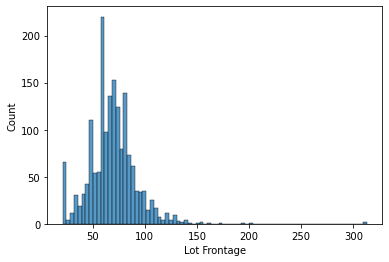

In [738]:
sns.histplot(df['Lot Frontage'])

<AxesSubplot:>

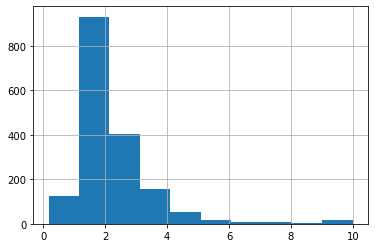

In [739]:
(df['Lot Area']/df['Lot Frontage']**2).clip(upper = 10).hist()

In [740]:
lot = (df['Lot Area']/df['Lot Frontage']**2) 

In [741]:
lot[lot < 1]

5       0.878683
20      0.734282
45      0.967000
95      0.550469
116     0.988806
          ...   
1920    0.625000
1932    0.628311
1952    0.175915
1994    0.953333
2023    0.675117
Length: 67, dtype: float64

In [742]:
df['Lot Area'].min()

1300

In [743]:
lf_na = df[df['Lot Frontage'].isna()][['MS Zoning', 'Lot Frontage', 'Lot Area', 'Alley', 'Lot Shape', 
                                'Land Contour', 'Lot Config', 'Land Slope', 'Neighborhood', 'SalePrice']]

In [744]:
lf_na.sample(8)

,MS Zoning,Lot Frontage,Lot Area,Alley,Lot Shape,Land Contour,Lot Config,Land Slope,Neighborhood,SalePrice
1597,RL,NaN,9535,NaN,IR1,Lvl,Inside,Gtl,Sawyer,165000
1858,RL,NaN,14781,NaN,IR2,Lvl,CulDSac,Gtl,CollgCr,275000
1113,RL,NaN,8010,NaN,IR1,Lvl,Inside,Gtl,Gilbert,188000
731,RL,NaN,9303,NaN,IR1,Lvl,Corner,Gtl,Timber,204000
1313,RL,NaN,6820,NaN,IR1,Lvl,Corner,Gtl,StoneBr,212000
1933,RL,NaN,14762,NaN,IR2,Lvl,Corner,Gtl,Gilbert,169000
2016,RL,NaN,7791,NaN,IR1,Lvl,Inside,Gtl,Sawyer,129000
1998,RL,NaN,16635,NaN,IR1,Lvl,FR2,Gtl,NWAmes,215000


In [745]:
pd.merge(df['Lot Config'].value_counts(), lf_na['Lot Config'].value_counts(), left_index= True, right_index = True)

,Lot Config_x,Lot Config_y
Inside,1503,190
Corner,348,67
CulDSac,131,61
FR2,60,11
FR3,9,1


In [746]:
pd.merge(df['Lot Shape'].value_counts(), lf_na['Lot Shape'].value_counts(), left_index= True, right_index = True)

,Lot Shape_x,Lot Shape_y
Reg,1295,85
IR1,692,223
IR2,55,19
IR3,9,3


In [747]:
gb_comp('Lot Config')

,Count,LogPrice_mean,base_residual_mean
Lot Config,,,
Inside,1503,12.003820,0.004150
Corner,348,12.024375,-0.000468
CulDSac,131,12.274239,-0.043155
FR2,60,12.020466,0.044953
FR3,9,12.092076,0.025318


In [748]:
gb_comp('Lot Shape')

,Count,LogPrice_mean,base_residual_mean
Lot Shape,,,
Reg,1295,11.922479,0.008435
IR1,692,12.194837,-0.010014
IR2,55,12.304131,-0.054350
IR3,9,12.115709,0.260278


In [749]:
gb_comp('Land Contour')

,Count,LogPrice_mean,base_residual_mean
Land Contour,,,
Lvl,1843,12.017072,0.002117
HLS,85,12.375379,-0.028011
Bnk,80,11.810727,0.067459
Low,43,12.092474,-0.083031


In [750]:
gb_comp('Land Slope')

,Count,LogPrice_mean,base_residual_mean
Land Slope,,,
Gtl,1953,12.021665,0.004758
Mod,88,12.104422,-0.056121
Sev,10,12.070493,-0.100677


In [751]:
def lot_clean(df):
    df['Lot Shape'] = ord_read('Lot Shape', ['Reg', 'IR1', 'IR2', 'IR3'], df = df)
    df['Land Slope'] = ord_read('Land Slope', ['Gtl', 'Mod', 'Sev'], df = df)
    df['Lot Ratio'] = df['Lot Area']/df['Lot Frontage']**2

#### Masonry

In [752]:
df['Mas Vnr Type'].value_counts(dropna=False)

None       1218
BrkFace     630
Stone       168
NaN          22
BrkCmn       13
Name: Mas Vnr Type, dtype: int64

In [753]:
df_test['Mas Vnr Type'].value_counts(dropna = False)

None       534
BrkFace    250
Stone       80
BrkCmn      12
CBlock       1
NaN          1
Name: Mas Vnr Type, dtype: int64

In [754]:
df['Mas Vnr Area'].value_counts(dropna = False)

0.0      1216
NaN        22
120.0      11
176.0      10
200.0      10
         ... 
142.0       1
215.0       1
235.0       1
233.0       1
426.0       1
Name: Mas Vnr Area, Length: 374, dtype: int64

In [755]:
def masonry_clean(df):
    df['Mas Vnr Type'].fillna('None', inplace = True)
    df['Mas Vnr Area'].fillna(0.0, inplace = True)

#### Basement

Note that the basement bathrooms are handled later.

In [756]:
basement = df.loc[:, "Bsmt Qual":"Total Bsmt SF"].copy()
basement['LogPrice_clipped'] = df['LogPrice_clipped']
basement['base_residual'] = df['base_residual']

In [757]:
basement.head()

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,LogPrice_clipped,base_residual
0,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,11.779129,0.280580
1,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,12.301383,0.044222
2,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,11.599103,0.139583
3,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,12.066811,-0.007865
4,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,11.838626,-0.115473


##### NA checks

3 unfinished basements are marked as good quality.

In [758]:
basement[basement['Bsmt Exposure'].isna() & ~basement['Bsmt Qual'].isna()]

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,LogPrice_clipped,base_residual
1456,Gd,TA,NaN,Unf,0.0,Unf,0.0,725.0,725.0,12.264856,-0.236199
1547,Gd,TA,NaN,Unf,0.0,Unf,0.0,1595.0,1595.0,12.308178,0.068318
1997,Gd,TA,NaN,Unf,0.0,Unf,0.0,936.0,936.0,12.167851,0.152073


In [759]:
basement[basement['BsmtFin SF 1'].isna()]

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,LogPrice_clipped,base_residual
1327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.277203,0.223866


In [760]:
df.iloc[1327].isna().sum()

15

##### Basement Quality and condition

In [761]:
basement.fillna({'Bsmt Qual': 'NA', 'Bsmt Cond': 'NA'}, inplace = True)

Looks like relationship of basement qual to log price is increasing and likely either linear or quadratic.

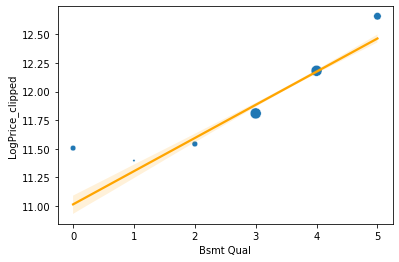

In [762]:
ord_plot('Bsmt Qual', 'qual_na', df = basement)

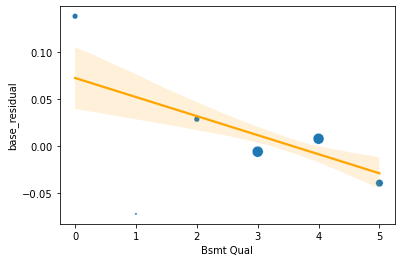

In [763]:
ord_plot('Bsmt Qual', 'qual_na', col = 'base_residual', df = basement)

In [764]:
basement['Bsmt Qual'].value_counts()

TA    887
Gd    864
Ex    184
Fa     60
NA     55
Po      1
Name: Bsmt Qual, dtype: int64

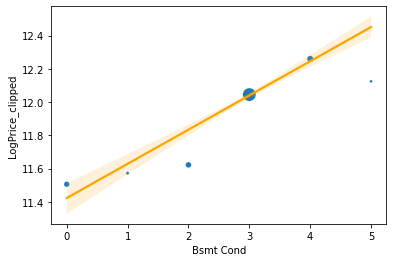

In [765]:
ord_plot('Bsmt Cond', 'qual_na', df = basement)

Interestingly, the relationship of basement condition to price is a bit unclear, however, it does have a clear linear relationship with our base residuals.

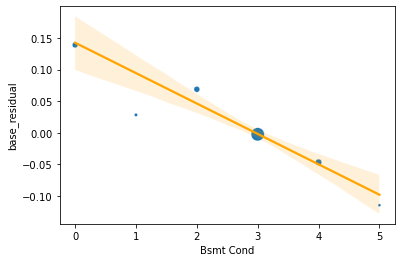

In [766]:
ord_plot('Bsmt Cond', 'qual_na', 'base_residual', basement)

Basement condition has almost all values typical so it has low coverage but, it is useful information to the model where it deviates from the mode.

In [767]:
basement['Bsmt Cond'].value_counts()

TA    1834
Gd      89
Fa      65
NA      55
Po       5
Ex       3
Name: Bsmt Cond, dtype: int64

In [768]:
basement.groupby(['Bsmt Cond', 'Bsmt Qual']).count()[['LogPrice_clipped']]

LogPrice_clipped
Bsmt Cond Bsmt Qual                  
Ex        Gd                        1
          TA                        2
Fa        Fa                       14
          Gd                        3
          Po                        1
          TA                       47
Gd        Ex                       20
          Fa                        2
          Gd                       47
          TA                       20
NA        NA                       55
Po        Ex                        1
          Fa                        3
          TA                        1
TA        Ex                      163
          Fa                       41
          Gd                      813
          TA                      817

##### Exposure

In [769]:
basement.fillna({'Bsmt Exposure': 'NA'}, inplace = True)

In [770]:
basement['Bsmt Exposure'].value_counts()

No    1339
Av     288
Gd     203
Mn     163
NA      58
Name: Bsmt Exposure, dtype: int64

In [771]:
basement.groupby('Bsmt Exposure').mean()[['LogPrice_clipped', 'base_residual']]

,LogPrice_clipped,base_residual
Bsmt Exposure,,
Av,12.165019,-0.021823
Gd,12.431982,-0.075246
Mn,12.082472,-0.001606
NA,11.543848,0.131226
No,11.947724,0.013112


Linear fit between exposure and log price

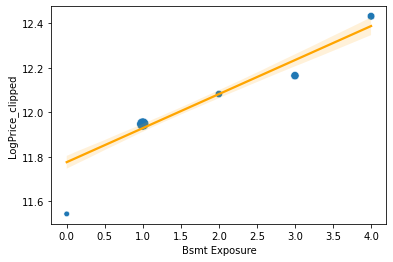

In [772]:
ord_plot('Bsmt Exposure', ['NA', 'No', 'Mn', 'Av', 'Gd'], df = basement)

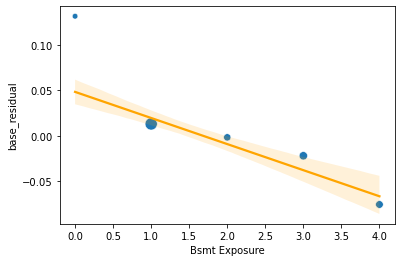

In [773]:
ord_plot('Bsmt Exposure', ['NA', 'No', 'Mn', 'Av', 'Gd'], col = 'base_residual',df = basement)

##### Finish type

For the first type, "GLQ" (Good Living Quarters) has significantly more value (~ 1 sd) than the others, the rest are approximately equal.

In [774]:
basement['BsmtFin Type 1'].value_counts()

GLQ    615
Unf    603
ALQ    293
BLQ    200
Rec    183
LwQ    102
Name: BsmtFin Type 1, dtype: int64

In [775]:
basement.groupby('BsmtFin Type 1')['LogPrice_clipped'].mean().sort_values()

BsmtFin Type 1
Rec    11.829262
BLQ    11.879686
LwQ    11.889080
Unf    11.933978
ALQ    11.970576
GLQ    12.316192
Name: LogPrice_clipped, dtype: float64

For the second type, good quality basements are also worth a bit more than average so I'll count this in the good quality basement feature.

In [776]:
basement['BsmtFin Type 2'].value_counts()

Unf    1749
Rec      80
LwQ      60
BLQ      48
ALQ      35
GLQ      23
Name: BsmtFin Type 2, dtype: int64

In [777]:
basement.groupby('BsmtFin Type 2')['LogPrice_clipped'].mean().sort_values()

BsmtFin Type 2
BLQ    11.913247
LwQ    11.965819
Rec    11.969344
Unf    12.045873
ALQ    12.062562
GLQ    12.221455
Name: LogPrice_clipped, dtype: float64

In [778]:
basement.query('`BsmtFin Type 2` == "GLQ"')

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,LogPrice_clipped,base_residual
32,Gd,Gd,Av,LwQ,437.0,GLQ,1057.0,0.0,1494.0,12.506177,-0.081089
92,Gd,TA,No,LwQ,36.0,GLQ,596.0,122.0,754.0,12.122691,0.036467
191,Gd,Gd,Gd,LwQ,51.0,GLQ,915.0,0.0,966.0,12.538967,-0.043086
271,Gd,TA,Mn,Rec,207.0,GLQ,590.0,36.0,833.0,11.917724,-0.142096
278,Gd,TA,No,LwQ,81.0,GLQ,612.0,23.0,716.0,11.925035,0.081069
300,Gd,TA,Gd,LwQ,560.0,GLQ,670.0,0.0,1230.0,12.289954,0.056139
319,Gd,TA,Av,BLQ,228.0,GLQ,852.0,0.0,1080.0,12.568978,-0.114387
519,Gd,TA,Mn,BLQ,128.0,GLQ,842.0,0.0,970.0,12.751300,0.085417
608,TA,TA,No,ALQ,296.0,GLQ,547.0,230.0,1073.0,12.345835,-0.125970
793,Ex,TA,No,LwQ,144.0,GLQ,1127.0,379.0,1650.0,12.270220,0.008337


##### Bsmt SF

Total basement square footage is split in to 3 categories: finish 1, finish 2, unfinished section.

In [779]:
sf_identity = basement['Total Bsmt SF'] == \
    (basement['BsmtFin SF 1'] + basement['BsmtFin SF 2'] + basement['Bsmt Unf SF'])

In [780]:
basement[~sf_identity]

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,LogPrice_clipped,base_residual
1327,NA,NA,NA,NaN,NaN,NaN,NaN,NaN,NaN,11.277203,0.223866


The heatmap suggests that the most important of these for price is the total square footage. This is intuitive, so I'll drop the other columns.

<AxesSubplot:>

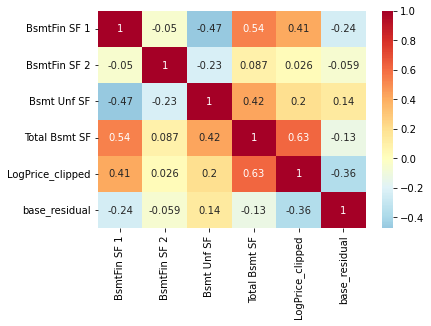

In [781]:
sns.heatmap(basement.corr(), center = 0, cmap = 'RdYlBu_r', annot = True)

In [782]:
sf_cols = [col for col in basement if basement[col].dtype == float]
sf_cols.remove('LogPrice_clipped')
sf_cols

['BsmtFin SF 1',
 'BsmtFin SF 2',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 'base_residual']

As a second check the total basement SF alone explans 39% of the variance in price compared to just barely more 40% with all SF features.

In [783]:
from sklearn.linear_model import LinearRegression
X = basement[sf_cols].fillna(0)

basement_sf_lr = LinearRegression()
basement_sf_lr.fit(X, basement['LogPrice_clipped'])
pd.DataFrame(basement_sf_lr.coef_, index = X.columns)
basement_sf_lr.score(X, basement['LogPrice_clipped'])

0.4757491718817576

In [784]:
X = basement[['Total Bsmt SF']].fillna(0)

basement_tot_sf_lr = LinearRegression()
basement_tot_sf_lr.fit(X, basement['LogPrice_clipped'])
# pd.DataFrame(basement_sf_lr.coef_, index = X.columns)
basement_tot_sf_lr.score(X, basement['LogPrice_clipped'])

0.39198467087035094

In [785]:
basement.head()

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,LogPrice_clipped,base_residual
0,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,11.779129,0.280580
1,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,12.301383,0.044222
2,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,11.599103,0.139583
3,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,12.066811,-0.007865
4,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,11.838626,-0.115473


##### Basement cleaning function

In [786]:
def basement_clean(df):
    df.fillna({'Bsmt Qual': 'NA', 'Bsmt Cond': 'NA', 'Bsmt Exposure': 'NA',
                'Total Bsmt SF': 0}, 
                inplace = True)
    df['Bsmt Qual'] = ord_read('Bsmt Qual', 'qual_na', df)
    df['Bsmt Cond'] = ord_read('Bsmt Cond', 'qual_na', df)
    df['Bsmt Exposure'] = ord_read('Bsmt Exposure', ['NA', 'No', 'Mn', 'Av', 'Gd'], df)
    df['Bsmt GLQ'] = ((df['BsmtFin Type 1'] == 'GLQ') | (df['BsmtFin Type 2'] == 'GLQ')).astype(int)
    df.drop(columns = ['Bsmt Cond', 'BsmtFin Type 1', 'BsmtFin Type 2',
                       'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF'], inplace = True)

#### Fireplaces

In [787]:
fire = df[['Fireplaces', 'Fireplace Qu', 'LogPrice_clipped', 'base_residual']].copy()

In [788]:
fire.head()

,Fireplaces,Fireplace Qu,LogPrice_clipped,base_residual
0,0,NaN,11.779129,0.280580
1,1,TA,12.301383,0.044222
2,0,NaN,11.599103,0.139583
3,0,NaN,12.066811,-0.007865
4,0,NaN,11.838626,-0.115473


Fire places can be capped at 2. Additonally, the relationship with price is non-linear so I'll add an extra indicator column 'is Fireplace'.

In [789]:
fire['Fireplaces'].value_counts()

0    1000
1     898
2     146
3       6
4       1
Name: Fireplaces, dtype: int64

In [790]:
fire.groupby('Fireplaces').mean()

,LogPrice_clipped,base_residual
Fireplaces,,
0,11.811912,0.022990
1,12.213636,-0.011385
2,12.315553,-0.077797
3,12.318392,0.301090
4,12.468437,0.131608


In [791]:
fire['Fireplace Qu'].fillna('NA', inplace = True)

In [792]:
fire['Fireplace Qu'].value_counts()

NA    1000
Gd     523
TA     407
Fa      59
Po      31
Ex      31
Name: Fireplace Qu, dtype: int64

In [793]:
fire.groupby('Fireplace Qu').mean()

,Fireplaces,LogPrice_clipped,base_residual
Fireplace Qu,,,
Ex,1.064516,12.657159,-0.022683
Fa,1.186441,12.024368,-0.047142
Gd,1.149140,12.281464,-0.021945
NA,0.000000,11.811912,0.022990
Po,1.000000,11.823423,-0.002781
TA,1.171990,12.188582,-0.011292


Fire quality appears to have an increasing linear or quadratic relationship w/ price.

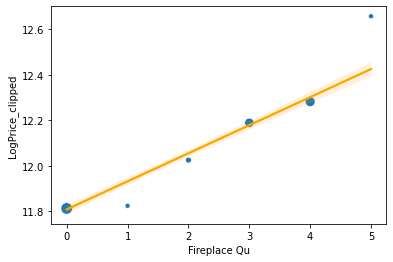

In [794]:
ord_plot('Fireplace Qu', 'qual_na',df = fire)

In [795]:
def fire_clean(df):
    df['Fireplaces'].clip(upper = 2, inplace = True)
    df['is Fireplace'] = (df['Fireplaces'] > 0).astype(int)
    df['Fireplace Qu'].fillna('NA', inplace = True)
    

#### Bath rooms

In [796]:
bathrooms = df.loc[:, 'Bsmt Full Bath': 'Half Bath']
# bathrooms['LogPrice_clipped'] = df['LogPrice_clipped']

In [797]:
bathrooms.head()

,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath
0,0.0,0.0,2,1
1,1.0,0.0,2,1
2,1.0,0.0,1,0
3,0.0,0.0,2,1
4,0.0,0.0,2,0


2 null values - these have no basement anyway, so we can fill them with 0

In [798]:
basement[df['Bsmt Half Bath'].isna()]

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,LogPrice_clipped,base_residual
616,NA,NA,NA,NaN,0.0,NaN,0.0,0.0,0.0,12.559191,-0.056535
1327,NA,NA,NA,NaN,NaN,NaN,NaN,NaN,NaN,11.277203,0.223866


In [799]:
bathrooms.fillna(0, inplace=True)

In [800]:
bathrooms.corr()

,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath
Bsmt Full Bath,1.000000,-0.146641,-0.011380,-0.026137
Bsmt Half Bath,-0.146641,1.000000,-0.060171,-0.047346
Full Bath,-0.011380,-0.060171,1.000000,0.153656
Half Bath,-0.026137,-0.047346,0.153656,1.000000


##### Sum all baths

In [801]:
bathrooms['Total Baths'] = bathrooms.sum(axis = 1)

In [802]:
bathrooms['Sum Baths'] = \
    (bathrooms['Bsmt Full Bath'] + bathrooms['Full Bath']) \
    + 1/2*(bathrooms['Bsmt Half Bath'] + bathrooms['Half Bath'])

In [803]:
bathrooms['LogPrice_clipped'] = df['LogPrice_clipped']
bathrooms['base_residual'] = df['base_residual']

In [804]:
bathrooms.head()

,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Total Baths,Sum Baths,LogPrice_clipped,base_residual
0,0.0,0.0,2,1,3.0,2.5,11.779129,0.280580
1,1.0,0.0,2,1,4.0,3.5,12.301383,0.044222
2,1.0,0.0,1,0,2.0,2.0,11.599103,0.139583
3,0.0,0.0,2,1,3.0,2.5,12.066811,-0.007865
4,0.0,0.0,2,0,2.0,2.0,11.838626,-0.115473


##### Correlation Testing

Based on the heat map the number of bathrooms has a strong correlation with price but not our base residuals.
Only the basement full bathrooms has a significant correlation remaining, but we already looked at other basement features that would capture this.

<AxesSubplot:>

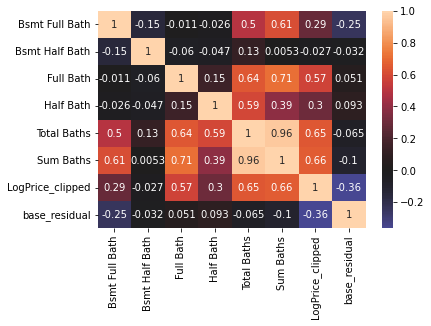

In [805]:
sns.heatmap(bathrooms.corr(), center = 0, annot = True)

<AxesSubplot:xlabel='Sum Baths', ylabel='LogPrice_clipped'>

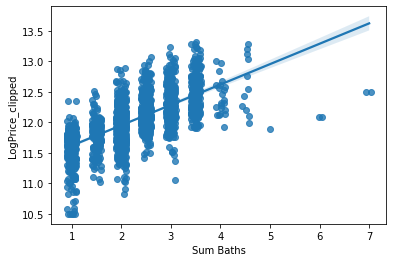

In [806]:
sns.regplot(x = 'Sum Baths', y = 'LogPrice_clipped', data = bathrooms, x_jitter=0.1)

<AxesSubplot:xlabel='Total Baths', ylabel='LogPrice_clipped'>

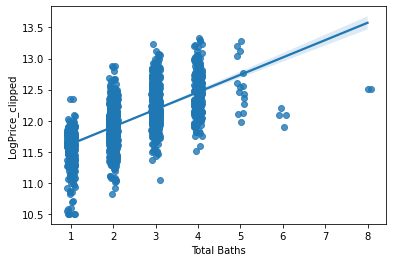

In [807]:
sns.regplot(x = 'Total Baths', y = 'LogPrice_clipped', data = bathrooms, x_jitter=0.1)

In [808]:
bathrooms.groupby('Sum Baths')[['LogPrice_clipped']].agg([np.mean, len])

LogPrice_clipped     
                      mean  len
Sum Baths                      
1.0              11.581006  315
1.5              11.806075  193
2.0              11.929565  636
2.5              12.170320  391
3.0              12.297845  278
3.5              12.498514  200
4.0              12.422703   22
4.5              12.629629   11
5.0              11.890677    1
6.0              12.095141    2
7.0              12.504324    2

In [809]:
bathrooms.groupby('Total Baths')[['LogPrice_clipped']].agg([np.mean, len])

LogPrice_clipped     
                        mean  len
Total Baths                      
1.0                11.581006  315
2.0                11.899188  815
3.0                12.226141  658
4.0                12.443810  242
5.0                12.590156   15
6.0                12.071758    4
8.0                12.504324    2

##### Outliers

In [810]:
many_bathrooms_idx = bathrooms.query('`Sum Baths` >= 5').index

In [811]:
all_cols(df.loc[many_bathrooms_idx])

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,base_residual,LogPrice_clipped
791,763,904301060,90,RL,60.0,10800,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,Duplex,1Story,5,5,1987,1988,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,Gd,Gd,GLQ,1200.0,Unf,0.0,0.0,1200.0,GasA,TA,Y,SBrkr,1200,0,0,1200,3.0,0.0,3,0,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,120,0,0,0,0,0,NaN,NaN,NaN,0,3,2009,WD,179000,-0.317941,12.095141
1325,1487,908102040,90,RL,67.0,8777,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Feedr,Norm,Duplex,1.5Fin,5,7,1900,2003,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1084.0,Unf,0.0,188.0,1272.0,GasA,Gd,Y,SBrkr,1272,928,0,2200,2.0,0.0,2,2,4,2,TA,9,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,N,0,70,0,0,0,0,NaN,GdPrv,NaN,0,9,2008,WD,145900,-0.071454,11.890677
1566,816,906230010,90,RL,NaN,11855,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,Duplex,2Story,7,5,2000,2000,Hip,CompShg,VinylSd,VinylSd,BrkFace,23.0,TA,TA,PConc,Ex,TA,No,GLQ,820.0,Unf,0.0,348.0,1168.0,GasA,Ex,Y,SBrkr,1168,1619,0,2787,2.0,0.0,4,2,6,2,TA,8,Typ,2,TA,BuiltIn,2000.0,Fin,4.0,820.0,TA,TA,Y,312,0,0,0,0,0,NaN,NaN,NaN,0,10,2009,WD,269500,0.059596,12.504324
1584,764,904301070,90,RL,60.0,10800,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,Duplex,1Story,5,5,1987,1988,Gable,CompShg,Plywood,Plywood,None,0.0,TA,Gd,CBlock,Gd,Gd,Gd,GLQ,1200.0,Unf,0.0,0.0,1200.0,GasA,TA,Y,SBrkr,1200,0,0,1200,3.0,0.0,3,0,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,120,0,0,0,0,0,NaN,NaN,NaN,0,3,2009,WD,179000,-0.317941,12.095141
1605,817,906230020,90,RL,NaN,7939,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Feedr,Norm,Duplex,2Story,7,5,2000,2000,Hip,CompShg,VinylSd,VinylSd,BrkFace,23.0,TA,TA,PConc,Ex,TA,No,GLQ,820.0,Unf,0.0,348.0,1168.0,GasA,Ex,Y,SBrkr,1168,1619,0,2787,2.0,0.0,4,2,6,2,TA,8,Typ,2,TA,BuiltIn,2000.0,Fin,4.0,820.0,TA,TA,Y,312,0,0,0,0,0,NaN,NaN,NaN,0,10,2009,WD,269500,0.059596,12.504324


Let's clip the bathrooms variable to limit outliers.

In [812]:
bathrooms['Sum clipped'] = bathrooms['Sum Baths'].clip(upper = 4.5)
bathrooms['Total clipped'] = bathrooms['Total Baths'].clip(upper = 5)

<AxesSubplot:>

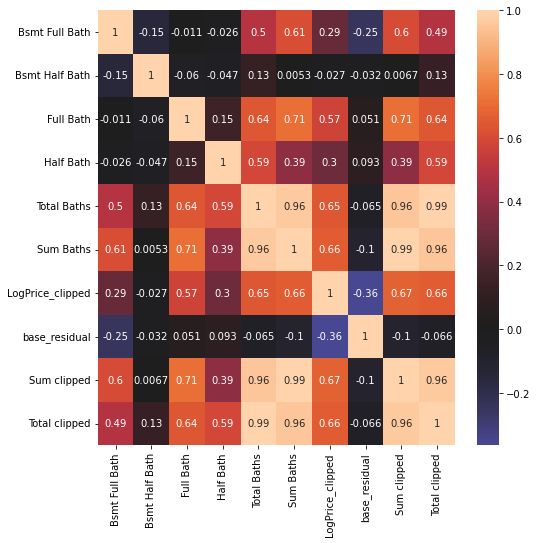

In [813]:
plt.figure(figsize = (8,8))
sns.heatmap(bathrooms.corr(), center = 0, annot = True)

##### Bathroom cleaning function

In [814]:
def bathroom_clean(df):
    df.fillna({'Bsmt Full Bath': 0, 'Bsmt Half Bath': 0}, inplace = True)
    df['Sum Bath'] = (df['Bsmt Full Bath'] + df['Full Bath']) + 1/2*(df['Bsmt Half Bath'] + df['Half Bath'])
    df.drop(columns = ['Bsmt Half Bath', 'Bsmt Full Bath', 'Full Bath', 'Half Bath'], inplace = True)

#### Garages

In [815]:
garage = df.loc[:, 'Garage Type': 'Garage Cond']

In [816]:
garage.head()

,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond
0,Attchd,1976.0,RFn,2.0,475.0,TA,TA
1,Attchd,1997.0,RFn,2.0,559.0,TA,TA
2,Detchd,1953.0,Unf,1.0,246.0,TA,TA
3,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA
4,Detchd,1957.0,Unf,2.0,484.0,TA,TA


In [817]:
garage[garage['Garage Cars'].isna()]

,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond
1712,Detchd,NaN,NaN,NaN,NaN,NaN,NaN


In [818]:
all_cols(df.loc[[1712], :])

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,base_residual,LogPrice_clipped
1712,2237,910201180,70,RM,50.0,9060,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,6,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,BrkTil,Gd,TA,No,ALQ,548.0,Unf,0.0,311.0,859.0,GasA,Ex,Y,SBrkr,942,886,0,1828,0.0,0.0,2,0,3,1,Gd,6,Typ,0,NaN,Detchd,NaN,NaN,NaN,NaN,NaN,NaN,Y,174,0,212,0,0,0,NaN,MnPrv,NaN,0,3,2007,WD,150909,-0.252457,11.924432


In [819]:
gb_comp('Garage Type')

,Count,LogPrice_mean,base_residual_mean
Garage Type,,,
Attchd,1213,12.169949,-0.014806
Detchd,536,11.750029,0.003551
BuiltIn,132,12.347318,0.050988
NaN,113,11.512542,0.092452
Basment,27,11.832160,0.045158
2Types,19,11.943087,-0.019590
CarPort,11,11.535601,0.125288


In [820]:
gb_comp('Garage Cars')

,Count,LogPrice_mean,base_residual_mean
Garage Cars,,,
2.0,1136,12.084108,0.001274
1.0,524,11.719646,0.004201
3.0,263,12.590220,-0.036983
0.0,113,11.512542,0.092452
4.0,13,12.288252,-0.048489
5.0,1,11.747998,-0.139758
NaN,1,11.924432,-0.252457


In [821]:
gb_comp('Garage Finish')

,Count,LogPrice_mean,base_residual_mean
Garage Finish,,,
Unf,849,11.809726,0.003332
RFn,579,12.178988,-0.005682
Fin,509,12.324702,-0.012548
NaN,114,11.516155,0.089426


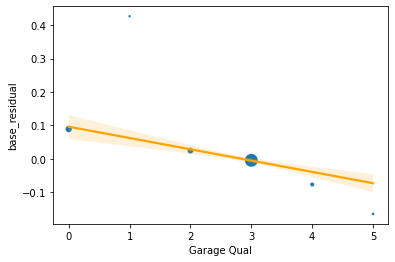

In [822]:
ord_plot('Garage Qual', 'qual_na', col = 'base_residual', df = df.fillna({'Garage Qual': 'NA'}))

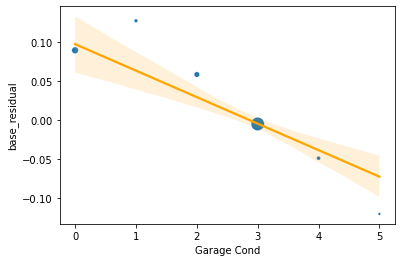

In [823]:
ord_plot('Garage Cond', 'qual_na', col = 'base_residual', df = df.fillna({'Garage Cond': 'NA'}))

<AxesSubplot:xlabel='Garage Area', ylabel='LogPrice_clipped'>

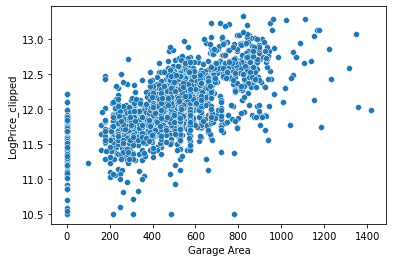

In [824]:
sns.scatterplot(x = 'Garage Area', y = 'LogPrice_clipped', data = df)

<AxesSubplot:xlabel='Garage Area', ylabel='base_residual'>

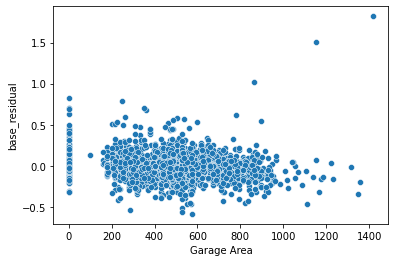

In [825]:
sns.scatterplot(x = 'Garage Area', y = 'base_residual', data = df)

<AxesSubplot:xlabel='Garage Yr Blt', ylabel='LogPrice_clipped'>

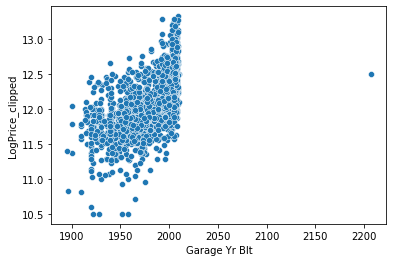

In [826]:
sns.scatterplot(x = 'Garage Yr Blt', y = 'LogPrice_clipped', data = df)

Garage Yr built has little additional info and is hard to impute so I'll drop it.

<AxesSubplot:xlabel='Garage Yr Blt', ylabel='base_residual'>

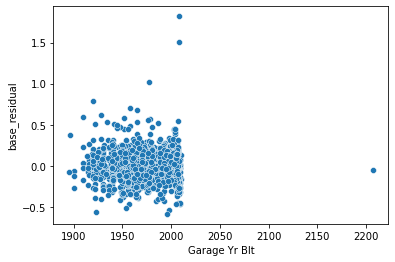

In [827]:
sns.scatterplot(x = 'Garage Yr Blt', y = 'base_residual', data = df)

Fix the outlier, house was renovated in 2007 so that is probably the correct value.

In [828]:
all_cols(df.query('`Garage Yr Blt` == 2207'))

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,base_residual,LogPrice_clipped
1699,2261,916384070,20,RL,68.0,8298,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,8,5,2006,2007,Hip,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,Av,GLQ,583.0,Unf,0.0,963.0,1546.0,GasA,Ex,Y,SBrkr,1564,0,0,1564,0.0,0.0,2,0,2,1,Ex,6,Typ,1,Gd,Attchd,2207.0,RFn,2.0,502.0,TA,TA,Y,132,0,0,0,0,0,NaN,NaN,NaN,0,9,2007,New,267300,-0.048181,12.496127


In [829]:
df.loc[1699, 'Garage Yr Blt'] = 2007

<AxesSubplot:xlabel='Garage Area', ylabel='Count'>

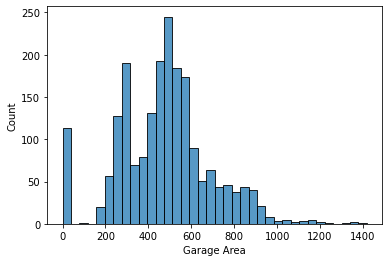

In [830]:
sns.histplot(x = 'Garage Area', data = garage)

In [831]:
garage['ratio'] = garage['Garage Area']/garage['Garage Cars']
garage[['LogPrice_clipped', 'base_residual']] = df[['LogPrice_clipped', 'base_residual']]

In [832]:
garage.corr()

,Garage Yr Blt,Garage Cars,Garage Area,ratio,LogPrice_clipped,base_residual
Garage Yr Blt,1.000000,0.579623,0.552069,0.021109,0.585382,0.004373
Garage Cars,0.579623,1.000000,0.893180,-0.193384,0.676896,-0.130240
Garage Area,0.552069,0.893180,1.000000,0.315036,0.660789,-0.141299
ratio,0.021109,-0.193384,0.315036,1.000000,-0.011572,-0.040744
LogPrice_clipped,0.585382,0.676896,0.660789,-0.011572,1.000000,-0.364360
base_residual,0.004373,-0.130240,-0.141299,-0.040744,-0.364360,1.000000


In [833]:
def garage_clean(df):
    df.drop(columns = 'Garage Yr Blt', inplace = True)
    df.fillna({'Garage Type': 'NA', 'Garage Finish': "NA", 'Garage Cars': 0, 'Garage Area': 0,
                 'Garage Qual': 'NA', 'Garage Cond': 'NA'}, inplace = True)
    df['Garage Ratio'] = df['Garage Area']/df['Garage Cars']

#### Fence

In [834]:
df['Fence'].value_counts()

MnPrv    227
GdPrv     83
GdWo      80
MnWw      10
Name: Fence, dtype: int64

In [835]:
# df['Fence'].fillna('NA', inplace = True)

Fence is tecnically ordinal (NA < MnWw < GdWo < MnPrv < GdPrv) but the relationship to both price and residuals are non linear. Therefore it would be better to OHE fence.

In [836]:
gb_comp('Fence')

,Count,LogPrice_mean,base_residual_mean
Fence,,,
NaN,1651,12.059895,0.005180
MnPrv,227,11.859423,-0.020492
GdPrv,83,12.031732,-0.023507
GdWo,80,11.807132,0.018316
MnWw,10,11.802545,-0.006761


In [837]:
def fence_clean(df):
    df['Fence'].fillna('NA', inplace = True)
    df['Fence'] = ord_read('Fence', ['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'], df = df)

#### Remodeling

* Last remodel = Year sold - year remodeled
* is remodeled = (Year remodeled - year built) > 0

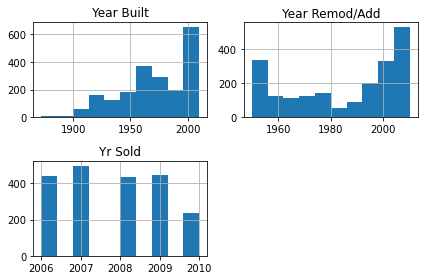

In [838]:
df[['Year Built', 'Year Remod/Add', 'Yr Sold']].hist()
plt.tight_layout()

In [839]:
last_remodel = df['Yr Sold'] - df['Year Remod/Add']

<AxesSubplot:ylabel='LogPrice_clipped'>

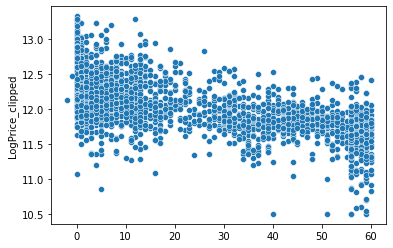

In [840]:
sns.scatterplot(x = last_remodel, y = df['LogPrice_clipped'])

<AxesSubplot:ylabel='base_residual'>

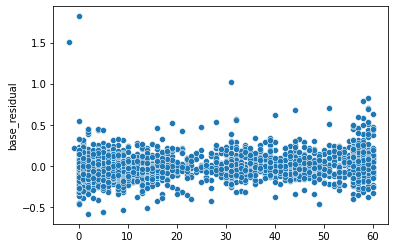

In [841]:
sns.scatterplot(x = last_remodel, y = df['base_residual'])

In [842]:
def remodel_features(df):
    df['is Remodeled'] = (df['Year Remod/Add'] > df['Year Built']).astype(int)
    df['Last Remodel'] = df['Yr Sold'] - df['Year Remod/Add']
    df.drop(columns = 'Year Remod/Add', inplace = True)

#### Shed

In [843]:
df['Misc Feature'].value_counts()

Shed    56
Gar2     4
Othr     3
TenC     1
Elev     1
Name: Misc Feature, dtype: int64

In [844]:
def misc_clean(df):
    df['is Shed'] = (df['Misc Feature'] == 'Shed').astype(int)
    df.drop(columns = 'Misc Feature', inplace = True)

#### Porch

In [845]:
porch = df.loc[:, 'Wood Deck SF': 'Screen Porch']

In [846]:
porch['Porch SF'] = porch.sum(axis = 1)
porch.head()

,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Porch SF
0,0,44,0,0,0,44
1,0,74,0,0,0,74
2,0,52,0,0,0,52
3,100,0,0,0,0,100
4,0,59,0,0,0,59


In [847]:
porch[['LogPrice_clipped', 'base_residual']] = df[['LogPrice_clipped', 'base_residual']]

In [848]:
porch.corr()

,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Porch SF,LogPrice_clipped,base_residual
Wood Deck SF,1.000000,0.047630,-0.114079,-0.010851,-0.067770,0.754074,0.332487,-0.110633
Open Porch SF,0.047630,1.000000,-0.077019,-0.007336,0.059027,0.446315,0.331005,-0.017293
Enclosed Porch,-0.114079,-0.077019,1.000000,-0.032145,-0.069049,0.220258,-0.151944,-0.040999
3Ssn Porch,-0.010851,-0.007336,-0.032145,1.000000,-0.029574,0.123189,0.055356,-0.055455
Screen Porch,-0.067770,0.059027,-0.069049,-0.029574,1.000000,0.298058,0.126852,-0.142793
Porch SF,0.754074,0.446315,0.220258,0.123189,0.298058,1.000000,0.402309,-0.171259
LogPrice_clipped,0.332487,0.331005,-0.151944,0.055356,0.126852,0.402309,1.000000,-0.364360
base_residual,-0.110633,-0.017293,-0.040999,-0.055455,-0.142793,-0.171259,-0.364360,1.000000


In [849]:
def porch_clean(df):
    df['Porch SF'] = df.loc[:, 'Wood Deck SF': 'Screen Porch'].sum(axis = 1)
    df.drop(columns = df.loc[:, 'Wood Deck SF': 'Screen Porch'].columns, inplace = True)

#### Building type, style + condition

Most of the Subclass info is redundant with housing style, building type, and age. However planned unit development type (codes 120, 150, 160, and 180) information is only in this feature.

In [850]:
gb_comp('MS SubClass')

,Count,LogPrice_mean,base_residual_mean
MS SubClass,,,
20,770,12.070455,-0.041447
60,394,12.341172,0.037798
50,198,11.780833,0.000120
120,132,12.224061,0.016471
30,101,11.413544,0.036808
70,90,11.897696,-0.019110
160,88,11.797773,0.108261
80,86,12.021979,-0.006358
90,75,11.804280,0.126696


Due to low coverage, I will merge values other than RL (low density residential), RM (mid density residential), and FV (floating village residential) as other.

In [851]:
gb_comp('MS Zoning')

,Count,LogPrice_mean,base_residual_mean
MS Zoning,,,
RL,1598,12.086148,-0.003243
RM,316,11.709021,0.012057
FV,101,12.267266,0.013055
C (all),19,11.178979,0.123979
RH,14,11.880476,0.032441
A (agr),2,10.904179,0.293549
I (all),1,10.961712,0.003057


In [852]:
zone_types_main = ['RL', 'RM', 'FV']

In [853]:
# This variable captures some of the resiudal.
gb_comp('House Style')

,Count,LogPrice_mean,base_residual_mean
House Style,,,
1Story,1059,12.008871,-0.020016
2Story,598,12.164791,0.044629
1.5Fin,218,11.777895,0.006408
SLvl,94,11.998892,-0.006778
SFoyer,50,11.889951,-0.064097
2.5Unf,14,12.084308,-0.002918
1.5Unf,12,11.611399,-0.013070
2.5Fin,6,12.295835,0.082943


In [854]:
gb_comp('Bldg Type')

,Count,LogPrice_mean,base_residual_mean
Bldg Type,,,
1Fam,1700,12.043811,-0.010607
TwnhsE,161,12.144949,0.032583
Duplex,75,11.804280,0.126696
Twnhs,69,11.758051,0.089523
2fmCon,46,11.690514,0.009844


##### Conditions
These all have significant correlation with the base model residuals, so we should keep them.
I'll combine some categories:
* Cond Feedr - adjacent to feeder street
* Cond Artery - adjacent to artery street
* Cond Pos - near or adjacent to positive feature
* Cond RR - near or adjacent to rail road.

In [855]:
gb_comp('Condition 1')

,Count,LogPrice_mean,base_residual_mean
Condition 1,,,
Norm,1767,12.046212,-0.003387
Feedr,109,11.817330,0.048646
Artery,70,11.700797,0.065988
RRAn,36,12.009676,0.034012
PosN,27,12.358938,-0.074950
RRAe,21,11.835450,0.044195
PosA,12,12.397077,-0.103817
RRNn,6,12.137509,0.076859
RRNe,3,11.743715,0.021575


In [856]:
gb_comp('Condition 2')

,Count,LogPrice_mean,base_residual_mean
Condition 2,,,
Norm,2025,12.026050,0.001431
Feedr,11,11.725777,0.034106
Artery,5,11.676611,0.102912
PosA,3,12.866217,-0.139628
PosN,3,12.878706,-0.111931
RRNn,2,11.435329,0.010011
RRAe,1,12.154779,0.144195
RRAn,1,11.827043,0.149254


In [857]:
def style_clean(df):
    df['is PUD'] = (df['MS SubClass'].apply(lambda x: x in (120, 150, 160, 180))).astype(int)
    df['Cond Feeder'] = ((df['Condition 1'] == 'Feedr') | (df['Condition 2'] == 'Feedr')).astype(int)
    df['Cond Artery'] = ((df['Condition 1'] == 'Artery') | (df['Condition 2'] == 'Artery')).astype(int)
    df['Cond Pos'] = ((df['Condition 1'].str[:3] == 'Pos') | (df['Condition 2'].str[:3] == 'Pos')).astype(int)
    df['Cond RR'] = ((df['Condition 1'].str[:2] == 'RR') | (df['Condition 2'].str[:2] == 'RR')).astype(int)
    df['MS Zoning'] = df['MS Zoning'].transform(\
        lambda x: x if x in zone_types_main else 'other')
    df.drop(columns = ['MS SubClass', 'Condition 1', 'Condition 2'], inplace=True)

#### Roof + Exterior

In [858]:
gb_comp('Roof Style')

,Count,LogPrice_mean,base_residual_mean
Roof Style,,,
Gable,1619,11.982786,0.006725
Hip,397,12.208429,-0.025007
Flat,13,12.113191,-0.037607
Gambrel,12,11.722418,0.057408
Mansard,7,11.790081,0.289998
Shed,3,12.219249,0.052318


In [859]:
gb_comp('Roof Matl') # drop - nearly all are same

,Count,LogPrice_mean,base_residual_mean
Roof Matl,,,
CompShg,2025,12.022169,0.001252
Tar&Grv,15,12.100663,-0.021502
WdShngl,5,12.709791,-0.142275
WdShake,4,12.469304,0.056511
ClyTile,1,11.982929,1.821340
Membran,1,12.394625,-0.201440


In [860]:
gb_comp('Exterior 1st') # drop for now

,Count,LogPrice_mean,base_residual_mean
Exterior 1st,,,
VinylSd,724,12.226670,0.004640
MetalSd,331,11.871761,-0.001061
HdBoard,300,11.946646,0.001450
Wd Sdng,276,11.804471,0.006062
Plywood,152,12.010029,-0.006523
CemntBd,90,12.253376,-0.023029
BrkFace,64,12.082571,-0.057460
WdShing,45,11.882517,-0.001931
AsbShng,33,11.482279,0.083084


In [861]:
gb_comp('Exterior 2nd')

,Count,LogPrice_mean,base_residual_mean
Exterior 2nd,,,
VinylSd,721,12.223507,0.003507
MetalSd,324,11.880501,-0.003082
HdBoard,275,11.951958,-0.001090
Wd Sdng,262,11.817427,-0.002198
Plywood,185,11.984297,-0.010336
CmentBd,90,12.241694,-0.023614
Wd Shng,63,11.873990,0.030847
BrkFace,34,12.046348,-0.024541
Stucco,30,11.841855,0.048787


In [862]:
# not significant
exterior_diff = df['Exterior 1st'] != df['Exterior 2nd']
df.groupby(exterior_diff).agg([len, np.mean])[['LogPrice_clipped', 'base_residual']]

LogPrice_clipped            base_residual          
                   len       mean           len      mean
False             1733  12.027424          1733  0.003936
True               318  12.014717           318 -0.010928

In [863]:
gb_comp('Foundation') # drop for now

,Count,LogPrice_mean,base_residual_mean
Foundation,,,
PConc,926,12.272964,0.000046
CBlock,863,11.864346,-0.005539
BrkTil,221,11.700045,0.012656
Slab,34,11.521777,0.172567
Stone,5,11.791390,-0.106412
Wood,2,12.051977,-0.024335


In [864]:
gb_comp('Exter Qual') # drop for now

,Count,LogPrice_mean,base_residual_mean
Exter Qual,,,
TA,1247,11.831790,0.000787
Gd,697,12.308442,0.003872
Ex,81,12.796475,-0.047010
Fa,26,11.325569,0.133605


In [865]:
df['Exter Cond'].value_counts(dropna = False)

TA    1778
Gd     215
Fa      49
Ex       7
Po       2
Name: Exter Cond, dtype: int64

In [866]:
gb_comp('Exter Cond') # exterior condition might matter - others not much.

,Count,LogPrice_mean,base_residual_mean
Exter Cond,,,
TA,1778,12.048598,0.004756
Gd,215,11.969120,-0.052710
Fa,49,11.446752,0.128690
Ex,7,12.257500,-0.111802
Po,2,10.872523,0.350096


In [867]:
def exter_clean(df):
    df.drop(columns = ['Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Foundation', 'Exter Qual'], inplace = True)
    df['Exter Cond'] = ord_read('Exter Cond', df = df)

#### Utilities, Heating, AC

In [868]:
gb_comp('Heating') # drop low coverage

,Count,LogPrice_mean,base_residual_mean
Heating,,,
GasA,2018,12.031899,-0.000300
GasW,20,11.880029,-0.006104
Wall,6,11.254349,0.188175
Grav,5,11.044661,0.469276
OthW,2,11.741606,0.299735


In [869]:
gb_comp('Heating QC')

,Count,LogPrice_mean,base_residual_mean
Heating QC,,,
Ex,1065,12.213422,-0.013291
TA,597,11.797023,0.026837
Gd,319,11.926212,-0.017493
Fa,67,11.584673,0.100244
Po,3,11.151416,0.114327


In [870]:
gb_comp('Central Air')

,Count,LogPrice_mean,base_residual_mean
Central Air,,,
Y,1910,12.067640,-0.006803
N,141,11.453993,0.115887


In [871]:
gb_comp('Electrical')

,Count,LogPrice_mean,base_residual_mean
Electrical,,,
SBrkr,1868,12.065644,-0.002961
FuseA,140,11.663428,0.028100
FuseF,35,11.498470,0.106833
FuseP,7,11.306195,0.126596
Mix,1,11.112448,0.317645


In [872]:
def utility_clean(df):
    df['Heating QC'] = ord_read('Heating QC', df = df)
    df['Central Air'] = (df['Central Air'] == "Y").astype(int)
    df['Electrical'] = ord_read('Electrical', map_ = ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'], df = df)
    df.drop(columns = ['Heating'], inplace = True)

#### Deductions

In [873]:
gb_comp('Functional') # Can combine categories to Typ, Min, Mod, Maj, Sev

,Count,LogPrice_mean,base_residual_mean
Functional,,,
Typ,1915,12.040605,-0.001754
Min1,42,11.900317,-0.043404
Min2,42,11.867665,0.022403
Mod,29,11.778673,0.054463
Maj1,12,11.943721,0.172889
Maj2,7,11.307975,0.218970
Sal,2,10.659889,0.520623
Sev,2,11.405245,0.679450


In [874]:
def deduct_clean(df):
    df['Functional'] = df['Functional'].map(lambda s: s[:3]).replace({'Sal': 'Sev'})

#### Sell Date + Type

In [875]:
gb_comp('Sale Type') # drop for now

,Count,LogPrice_mean,base_residual_mean
Sale Type,,,
WD,1781,11.998657,0.000473
New,160,12.474179,-0.017633
COD,63,11.752229,0.077053
ConLD,17,11.660011,0.058423
CWD,10,12.096448,0.007440
ConLI,7,12.090451,0.051880
ConLw,5,11.665116,0.031758
Con,4,12.325255,-0.164116
Oth,4,11.723482,-0.115531


In [876]:
gb_comp('Mo Sold')

,Count,LogPrice_mean,base_residual_mean
Mo Sold,,,
6,352,12.034825,-0.004751
7,303,12.064846,-0.020796
5,257,12.027184,-0.020732
4,208,11.944976,0.014573
3,168,11.984876,0.017536
8,167,12.056399,0.000772
10,123,12.002986,0.019201
9,109,12.039939,0.012368
2,104,12.010948,0.023537


In [877]:
gb_comp('Yr Sold')

,Count,LogPrice_mean,base_residual_mean
Yr Sold,,,
2007,498,12.056093,-0.004113
2009,446,12.026430,0.004405
2006,438,12.008968,0.001990
2008,435,12.027602,0.004689
2010,234,11.985254,0.002218


In [878]:
df['MoYr Sold'] = df['Yr Sold'] + df['Mo Sold']/12
gb_comp('MoYr Sold')

,Count,LogPrice_mean,base_residual_mean
MoYr Sold,,,
2007.500000,83,12.084804,-0.042933
2006.583333,81,12.028548,-0.024245
2008.500000,78,12.094241,-0.004211
2009.583333,75,12.153279,-0.032104
2009.500000,73,12.032811,0.022697
2007.583333,72,12.050170,-0.034637
2008.583333,71,12.062021,0.000873
2006.500000,65,11.993084,-0.014515
2007.666667,56,12.102452,0.013073


In [879]:
def sale_clean(df):
    df['MoYr Sold'] = df['Yr Sold'] + df['Mo Sold']/12
    df.drop(columns = ['Sale Type'], inplace = True)

### All data cleaning.

In [880]:
def clean_data(df):
    df_clean = df.copy()

    df_clean.drop(columns='PID', inplace = True)
    df_clean.set_index('Id', inplace = True)

    # call all helpers
    neighborhood_clean(df_clean)
    pool_clean(df_clean)
    alley_clean(df_clean)
    masonry_clean(df_clean)
    lot_clean(df_clean)
    basement_clean(df_clean)
    fire_clean(df_clean)
    bathroom_clean(df_clean)
    garage_clean(df_clean)
    fence_clean(df_clean)
    misc_clean(df_clean)
    style_clean(df_clean)
    porch_clean(df_clean)
    deduct_clean(df_clean)
    exter_clean(df_clean)
    utility_clean(df_clean)
    sale_clean(df_clean)

    return df_clean

In [881]:
df_clean = clean_data(df)
df_test_clean = clean_data(df_test)

In [882]:
df_clean.columns

Index(['MS Zoning', 'Lot Frontage', 'Lot Area', 'Street', 'Alley', 'Lot Shape',
       'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood',
       'Bldg Type', 'House Style', 'Overall Qual', 'Overall Cond',
       'Year Built', 'Year Remod/Add', 'Roof Style', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Cond', 'Bsmt Qual', 'Bsmt Exposure',
       'Total Bsmt SF', 'Heating QC', 'Central Air', 'Electrical',
       '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area',
       'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd',
       'Functional', 'Fireplaces', 'Fireplace Qu', 'Garage Type',
       'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual',
       'Garage Cond', 'Paved Drive', 'Fence', 'Misc Val', 'Mo Sold', 'Yr Sold',
       'SalePrice', 'base_residual', 'LogPrice_clipped', 'MoYr Sold',
       'is Pool', 'Lot Ratio', 'Bsmt GLQ', 'is Fireplace', 'Sum Bath',
       'Garage Ratio', 'is Shed', 'is PUD', 'Cond Feeder', 'Cond Artery

In [883]:
df_clean.head()

,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,...,is Fireplace,Sum Bath,Garage Ratio,is Shed,is PUD,Cond Feeder,Cond Artery,Cond Pos,Cond RR,Porch SF
Id,,,,,,,,,,,,,,,,,,,,,
109,RL,NaN,13517,1,None,1,Lvl,AllPub,CulDSac,0,...,0,2.5,237.5,0,0,0,0,0,1,44
544,RL,43.0,11492,1,None,1,Lvl,AllPub,CulDSac,0,...,1,3.5,279.5,0,0,0,0,0,0,74
153,RL,68.0,7922,1,None,0,Lvl,AllPub,Inside,0,...,0,2.0,246.0,0,0,0,0,0,0,52
318,RL,73.0,9802,1,None,0,Lvl,AllPub,Inside,0,...,0,2.5,200.0,0,0,0,0,0,0,100
255,RL,82.0,14235,1,None,1,Lvl,AllPub,Inside,0,...,0,2.0,242.0,0,0,0,0,0,0,59


In [884]:
pd.DataFrame(df_clean.isna().sum(), columns = ['na_count']).query('na_count > 0')

,na_count
Lot Frontage,330
Lot Ratio,330
Garage Ratio,114


In [885]:
pd.DataFrame(df_test_clean.isna().sum(), columns = ['na_count']).query('na_count > 0')

,na_count
Lot Frontage,160
Electrical,1
Lot Ratio,160
Garage Ratio,44


In [886]:
df_test.query('Id == 1578')['Electrical']

634    NaN
Name: Electrical, dtype: object

For some reason this house has electrical marked as NA. It is a modern home, so I'll assume it has normal electricity (4)

In [887]:
all_cols(df_test_clean.loc[df_test_clean['Electrical'].isna(), :])

,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Mas Vnr Type,Mas Vnr Area,Exter Cond,Bsmt Qual,Bsmt Exposure,Total Bsmt SF,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Fence,Misc Val,Mo Sold,Yr Sold,is Pool,Lot Ratio,Bsmt GLQ,is Fireplace,Sum Bath,Garage Ratio,is Shed,is PUD,Cond Feeder,Cond Artery,Cond Pos,Cond RR,Porch SF,MoYr Sold
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1578,RL,73.0,9735,1,None,0,Lvl,AllPub,Inside,0,Timber,1Fam,SLvl,5,5,2006,2007,Gable,None,0.0,2,4,1,384,3,1,NaN,754,640,0,1394,3,1,Gd,7,Typ,0,NA,BuiltIn,Fin,2,400,TA,TA,Y,0,0,5,2008,0,1.826797,0,0,2.5,200.0,0,0,0,0,0,0,100,2008.416667


In [888]:
df_test_clean.loc[1578, 'Electrical'] = 4

### Impute missing values

* df['Lot Frontage'] mean imputation with missing indicator

In [889]:
from sklearn.impute import SimpleImputer
si = SimpleImputer()
impute_cols = ['Lot Frontage', 'Lot Ratio', 'Garage Ratio']
df_clean[impute_cols] = si.fit_transform(df_clean[impute_cols])
df_test_clean[impute_cols] = si.transform(df_test_clean[impute_cols])

### Feature engineering

Some feature engineering is done during the cleaning section. This is especially for functions that need to be done after imputing missing values and when imputation can't be done to a default value (0 or 'NA').

In [890]:
def feature_engineering(df):
    df_features = df.copy()

    # Feature engineering functions
    remodel_features(df_features)

    return df_features

In [891]:
df_final = feature_engineering(df_clean)
df_test_final = feature_engineering(df_test_clean)

In [892]:
pd.DataFrame(df_final.isna().sum(), columns = ['na_count']).query('na_count > 0')

,na_count


In [893]:
all_cols(df_final)

,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Roof Style,Mas Vnr Type,Mas Vnr Area,Exter Cond,Bsmt Qual,Bsmt Exposure,Total Bsmt SF,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Fence,Misc Val,Mo Sold,Yr Sold,SalePrice,base_residual,LogPrice_clipped,MoYr Sold,is Pool,Lot Ratio,Bsmt GLQ,is Fireplace,Sum Bath,Garage Ratio,is Shed,is PUD,Cond Feeder,Cond Artery,Cond Pos,Cond RR,Porch SF,is Remodeled,Last Remodel
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
109,RL,69.0552,13517,1,None,1,Lvl,AllPub,CulDSac,0,Sawyer,1Fam,2Story,6,8,1976,Gable,BrkFace,289.0,2,3,1,725.0,4,1,4,725,754,0,1479,3,1,Gd,6,Typ,0,NA,Attchd,RFn,2.0,475.0,TA,TA,Y,0,0,3,2010,130500,0.280580,11.779129,2010.250000,0,2.308955,1,0,2.5,237.5,0,0,0,0,0,1,44,1,5
544,RL,43.0000,11492,1,None,1,Lvl,AllPub,CulDSac,0,SawyerW,1Fam,2Story,7,5,1996,Gable,BrkFace,132.0,2,4,1,913.0,4,1,4,913,1209,0,2122,4,1,Gd,8,Typ,1,TA,Attchd,RFn,2.0,559.0,TA,TA,Y,0,0,4,2009,220000,0.044222,12.301383,2009.333333,0,6.215251,1,1,3.5,279.5,0,0,0,0,0,0,74,1,12
153,RL,68.0000,7922,1,None,0,Lvl,AllPub,Inside,0,NAmes,1Fam,1Story,5,7,1953,Gable,None,0.0,3,3,1,1057.0,2,1,4,1057,0,0,1057,3,1,Gd,5,Typ,0,NA,Detchd,Unf,1.0,246.0,TA,TA,Y,0,0,1,2010,109000,0.139583,11.599103,2010.083333,0,1.713235,1,0,2.0,246.0,0,0,0,0,0,0,52,1,3
318,RL,73.0000,9802,1,None,0,Lvl,AllPub,Inside,0,Timber,1Fam,2Story,5,5,2006,Gable,None,0.0,2,4,1,384.0,3,1,4,744,700,0,1444,3,1,TA,7,Typ,0,NA,BuiltIn,Fin,2.0,400.0,TA,TA,Y,0,0,4,2010,174000,-0.007865,12.066811,2010.333333,0,1.839369,0,0,2.5,200.0,0,0,0,0,0,0,100,1,3
255,RL,82.0000,14235,1,None,1,Lvl,AllPub,Inside,0,SawyerW,1Fam,1.5Fin,6,8,1900,Gable,None,0.0,2,2,1,676.0,2,1,4,831,614,0,1445,3,1,TA,6,Typ,0,NA,Detchd,Unf,2.0,484.0,TA,TA,N,0,0,3,2010,138500,-0.115473,11.838626,2010.250000,0,2.117043,0,0,2.0,242.0,0,0,0,0,0,0,59,1,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1587,RL,79.0000,11449,1,None,1,HLS,AllPub,Inside,0,Timber,1Fam,1Story,8,5,2007,Gable,None,0.0,2,4,3,1884.0,4,1,4,1728,0,0,1728,3,1,Gd,7,Typ,1,Gd,Attchd,Fin,2.0,520.0,TA,TA,Y,0,0,1,2008,298751,-0.105534,12.607366,2008.083333,0,1.834482,1,1,3.0,260.0,0,0,0,0,0,0,276,0,1
785,RL,69.0552,12342,1,None,1,Lvl,AllPub,Inside,0,Edwards,1Fam,1Story,4,5,1940,Gable,None,0.0,2,3,1,861.0,4,1,4,861,0,0,861,1,1,TA,4,Typ,0,NA,Detchd,Unf,2.0,539.0,TA,TA,Y,0,0,3,2009,82500,0.089703,11.320554,2009.250000,0,2.308955,0,0,1.0,269.5,0,0,0,0,0,0,158,1,59
916,RL,57.0000,7558,1,None,0,Bnk,AllPub,Inside,0,Crawfor,1Fam,1.5Fin,6,6,1928,Gable,None,0.0,2,3,1,896.0,3,1,4,1172,741,0,1913,3,1,TA,9,Typ,1,TA,Detchd,Unf,2.0,342.0,Fa,Fa,Y,0,0,3,2009,177000,0.081380,12.083905,2009.250000,0,2.326254,0,1,1.5,171.0,0,0,0,0,0,0,0,1,59


In [894]:
df['Fence'].head()

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: Fence, dtype: object

In [895]:
df_clean['Fence'].head()

Id
109    0
544    0
153    0
318    0
255    0
Name: Fence, dtype: int64

In [896]:
df_final.drop(columns = ['LogPrice_clipped', 'base_residual'], inplace = True)

In [897]:
# Write to file
df_final.to_csv('datasets/train_cleaned.csv')
df_test_final.to_csv('datasets/test_cleaned.csv')

**TODO** Test One hot encoding for unencountered values 